# Linealización de una no linealidad estática en el actuador

Se tiene una válvula con una característica de cuarto orden actuando sobre un sistema de tercer orden

Se ajusta un controlador PI y se realizan simulaciones para 2 casos donde en cada uno de ellos se contrastan los resultados de 
- linelizar completamente la característica de la válvula 
- aplicar una linealización por tramos
- no linealizar

/tmp/ipykernel_2075571/4095541157.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[k] = Cmat @ x + D * q


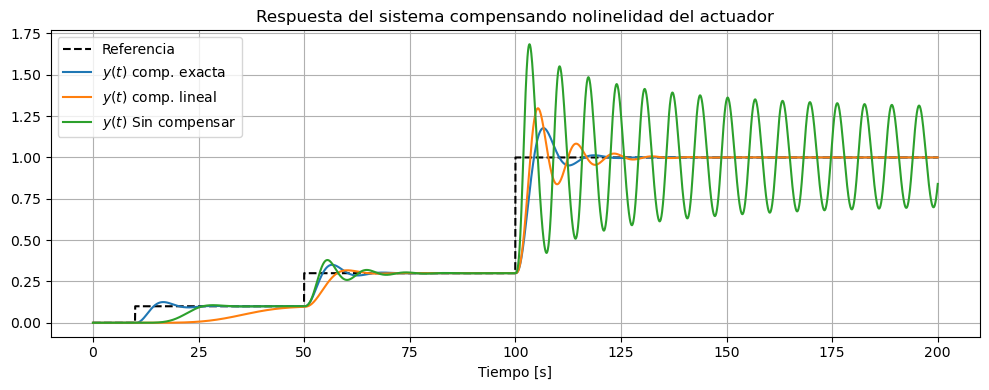

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

# --- Parámetros del controlador PI ---
Kp = 0.5
Ti = 1.0
s = ct.TransferFunction.s
C = Kp * (1 + s/Ti)

# --- Planta lineal ---
G = 1 / (s + 1)**3

# --- Simulación en lazo cerrado no lineal ---
def simulate(t,r, compensacion=0):
    """Simula el sistema con o sin compensación"""

    y = np.zeros_like(t)
    u = np.zeros_like(t)
    v = np.zeros_like(t)
    e_int = 0.0

    dt = t[1] - t[0]
    Gd = ct.sample_system(G,Ts=dt)
    Gss = ct.tf2ss(Gd)  # modelo en espacio de estados
    A, B, Cmat, D = Gss.A, Gss.B, Gss.C, Gss.D
    x = np.zeros(A.shape[0])

    for k in range(1, len(t)):
        e = r[k] - y[k-1]
        e_int += e * dt
        v[k] = Kp * e + (Kp/Ti) * e_int   # salida del PI

        if compensacion==0:
            u[k] = v[k]**(1/4)
        elif compensacion==1:
            if v[k]>3:
                u[k] = 0.0538 * v[k] + 1.139
            else:
                u[k] = 0.433 * v[k]            
        else:
            u[k] = v[k]

        # salida de la válvula
        q = u[k]**4

        # integración del sistema
        x = A @ x + B.flatten() * q
        y[k] = Cmat @ x + D * q

    return y, u, v

# --- Escenarios ---
t = np.linspace(0, 200, 4000)

# Sin compensación
r = np.zeros_like(t) 
r[t > 10] = 0.1  # salto en la referencia
r[t > 50] = 0.3  # salto en la referencia
r[t > 100] = 1  # salto en la referencia

plt.figure(figsize=(10,4))
plt.plot(t, r, 'k--', label='Referencia')

# Con compensación exacta
y, u, v = simulate(t,r, compensacion=0)
plt.plot(t, y, label='$y(t)$ comp. exacta')

# Con compensación por LUT
y, u, v = simulate(t,r, compensacion=1)
plt.plot(t, y, label='$y(t)$ comp. lineal')

# Sin compensación
y, u, v = simulate(t,r, compensacion=-1)
plt.plot(t, y, label='$y(t)$ Sin compensar')


plt.title("Respuesta del sistema compensando nolinelidad del actuador")
plt.grid(True)
plt.xlabel("Tiempo [s]")
plt.legend()

plt.tight_layout()
plt.show()
